In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

In [4]:
save_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management/"
file_name = "2024_predictions_win_only.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [5]:
max_odds_columns = odds.iloc[:, 2:5].idxmax(axis=1)
best_odds = []

for index,row in odds.iterrows():
    best_odds.append(row[max_odds_columns[index]])

max_odds = pd.DataFrame({
    'Date': odds['Timestamp'],
    'Teams': odds['Teams_x'],
    'Sportsbooks_Odds': best_odds
})

final = pd.merge(df, max_odds, on=['Date', 'Teams'], how='left')
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams', 'Sportsbooks_Odds', 'Our_Odds','Probabilities','Predictions', 'Actual']
final = final[column_order]
final

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual
0,2024-01-09,LAL,1.52,1.895107,0.527675,1,1
1,2024-01-01,LAC,1.35,1.759918,0.568208,1,1
2,2024-01-01,HOU,1.27,1.701114,0.587850,1,1
3,2024-01-01,DEN,1.09,1.363344,0.733490,1,1
4,2024-01-02,PHI,1.20,1.554104,0.643458,1,1
...,...,...,...,...,...,...,...
535,2024-03-20,CLE,1.77,1.959857,0.510241,1,0
536,2024-03-20,BOS,1.19,1.549348,0.645433,1,1
537,2024-03-20,GSW,1.17,1.524371,0.656008,1,1
538,2024-03-20,MIA,2.10,1.995509,0.501125,1,1


In [6]:
final[final['Our_Odds'] < final['Sportsbooks_Odds']]

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual
180,2024-01-26,OKC,2.00,1.952351,0.512203,1,1
194,2024-01-29,CLE,2.12,1.988585,0.502870,1,1
216,2024-01-31,SAC,2.00,1.954679,0.511593,1,0
220,2024-01-31,OKC,1.98,1.978475,0.505440,1,1
274,2024-02-08,MIN,1.96,1.937053,0.516248,1,1
332,2024-02-22,BRK,2.00,1.973723,0.506657,1,0
367,2024-02-25,ATL,2.00,1.990477,0.502392,1,1
390,2024-03-01,POR,2.00,1.981769,0.504600,1,1
406,2024-03-02,BRK,2.00,1.992246,0.501946,1,1
444,2024-03-06,CLE,2.20,1.985441,0.503666,1,0


In [5]:
testing = final[final['Sportsbooks_Odds'] > final['Our_Odds']]
testing['Kelly'] = kelly(testing['Sportsbooks_Odds'], testing['Probabilities'], 1)
testing

/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_54117/2095716274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['Kelly'] = kelly(testing['Sportsbooks_Odds'], testing['Probabilities'], 1)


,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,Kelly
180,2024-01-26,OKC,2.00,1.952351,0.512203,1,1,0.024406
194,2024-01-29,CLE,2.12,1.988585,0.502870,1,1,0.059004
216,2024-01-31,SAC,2.00,1.954679,0.511593,1,0,0.023186
220,2024-01-31,OKC,1.98,1.978475,0.505440,1,1,0.000787
274,2024-02-08,MIN,1.96,1.937053,0.516248,1,1,0.012340
332,2024-02-22,BRK,2.00,1.973723,0.506657,1,0,0.013313
367,2024-02-25,ATL,2.00,1.990477,0.502392,1,1,0.004784
390,2024-03-01,POR,2.00,1.981769,0.504600,1,1,0.009200
406,2024-03-02,BRK,2.00,1.992246,0.501946,1,1,0.003892
444,2024-03-06,CLE,2.20,1.985441,0.503666,1,0,0.090055


In [7]:
# something to investigate is using the sigmoid probabilites vs using the model's accuracy score
def backtest(df,initial, shrinkage):
    df = df.copy()
    df['Kelly'] = kelly(df['Sportsbooks_Odds'],0.718, shrinkage)

    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

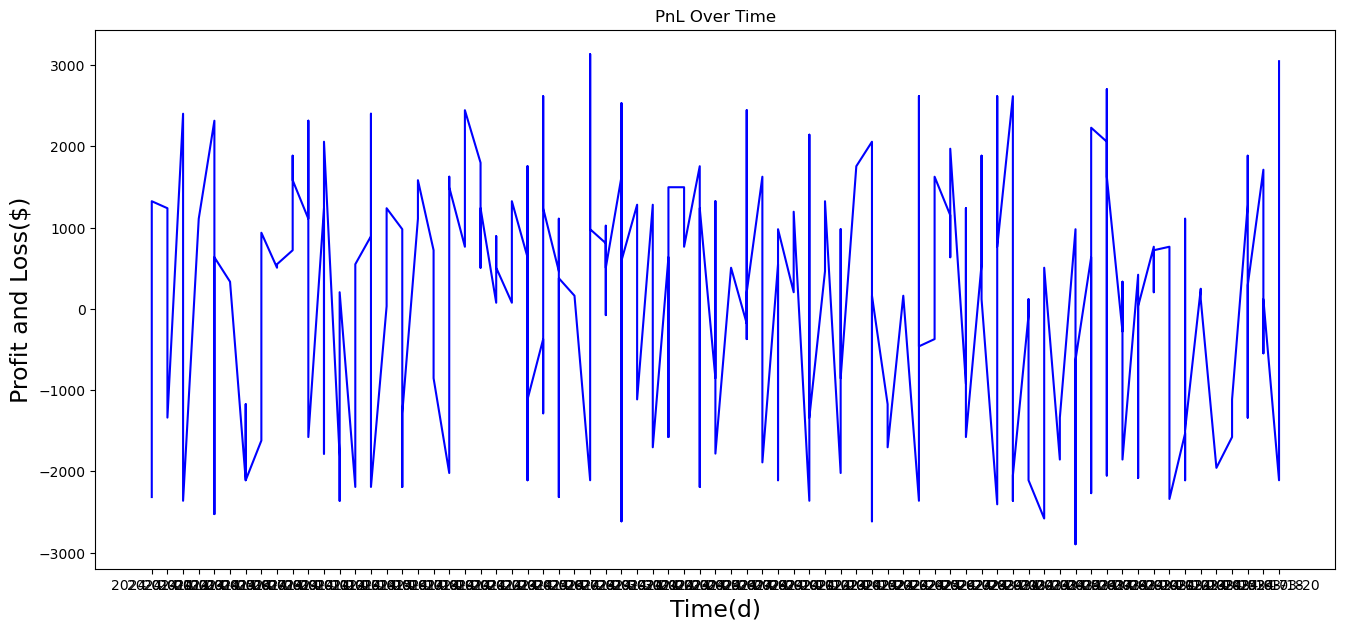

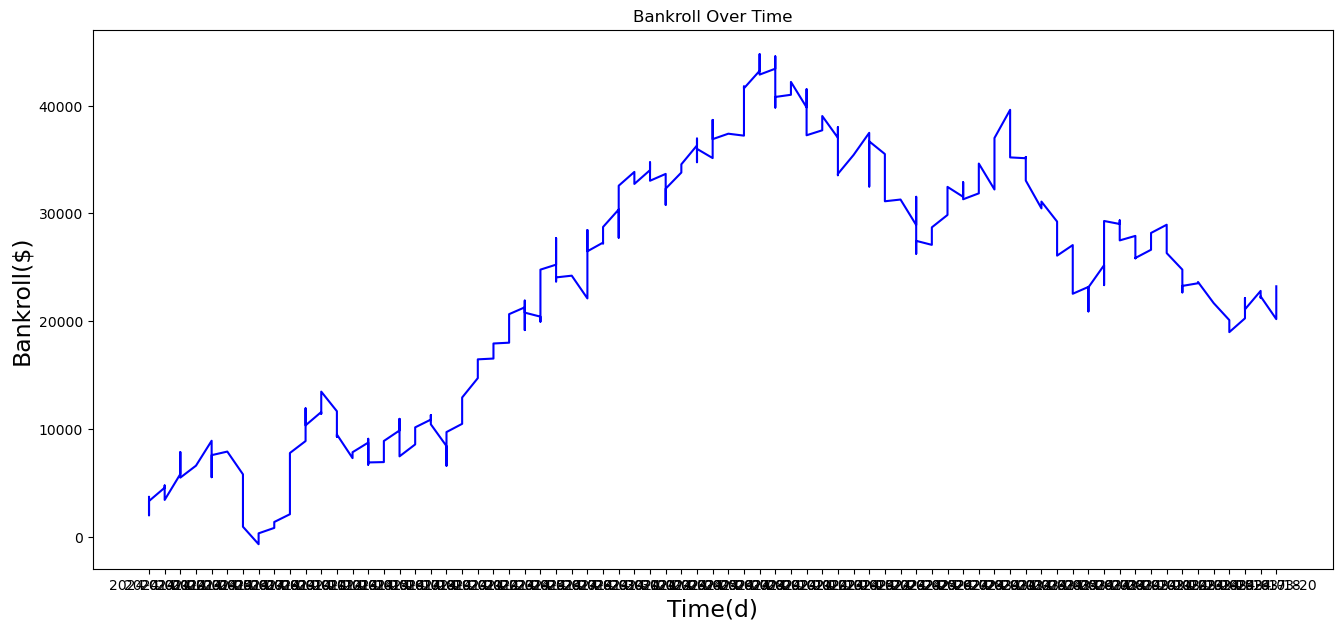



The position was held for 2 months, traded 281 times, and produced a return of 287.1173%.
The growth rate on each bet was 0.4829%.
The final balance is $23227.04.
The average of returns is 300.8338%.
The standard deviation of returns is 195.1686%.


The Sharpe Ratio of the strategy is 1.5414.


In [8]:
backtest(final, 6000, 1)

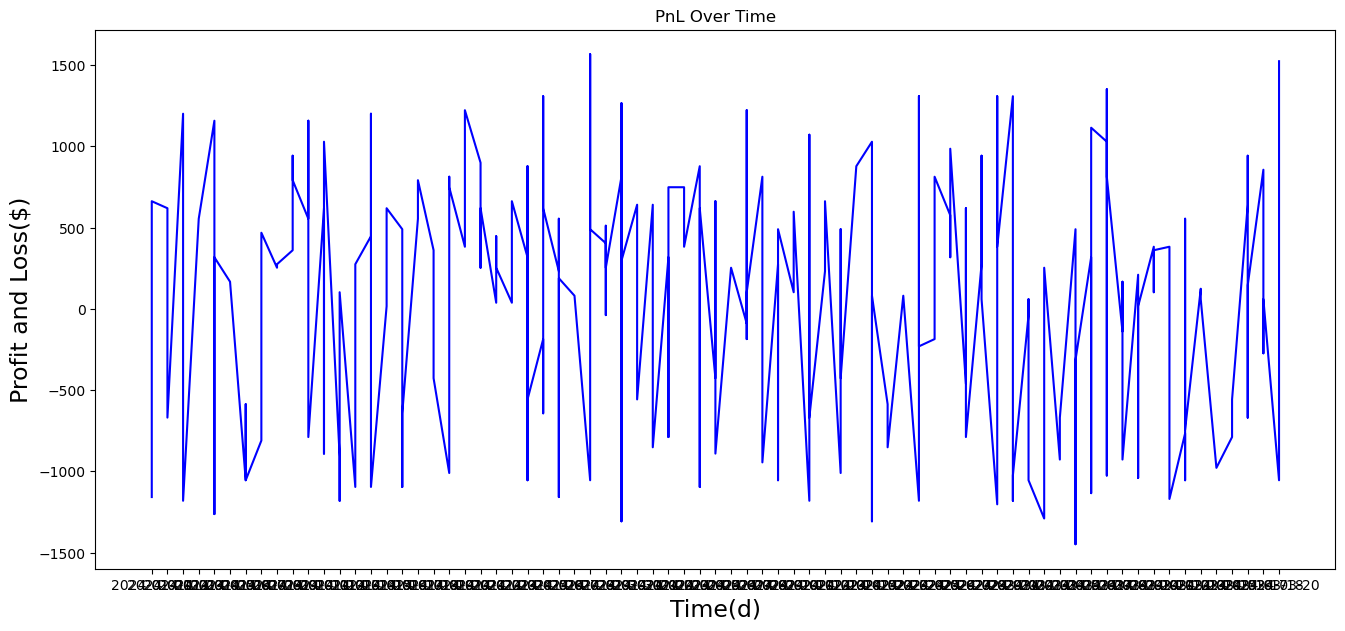

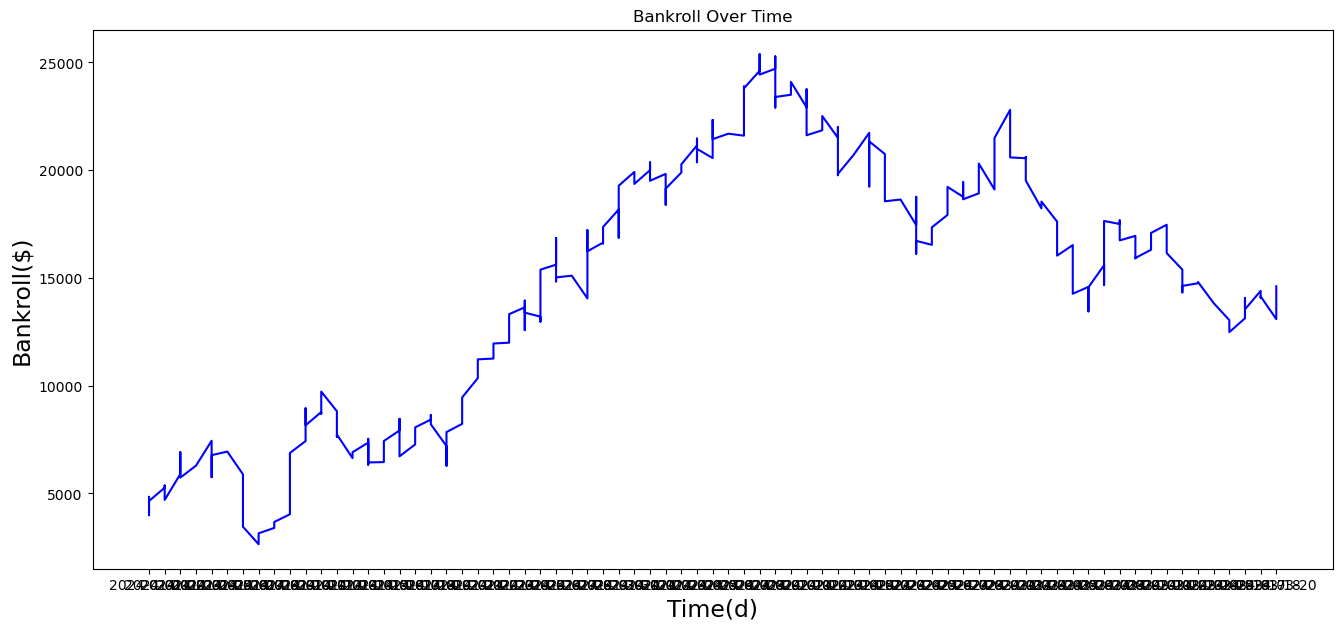



The position was held for 2 months, traded 281 times, and produced a return of 143.5587%.
The growth rate on each bet was 0.3173%.
The final balance is $14613.52.
The average of returns is 150.4169%.
The standard deviation of returns is 97.5843%.


The Sharpe Ratio of the strategy is 1.5414.


In [23]:
backtest(final, 6000, 0.5)